<font color=Blue>

# What
Image classification.  In particular, 
given 2 categories and a set of images in those categories,
train a model to correctly classify future examples.
# Why
If we extend to more than 2 images, then it is easy to imagine
industrial, agricultural or mainstream applications of
image classification.  For example, the automatic checkout at
the grocery store could recognize what kind of fruit you have.
Also, a weed kill sprayer on a tractor could 
distinguish between crops and weeds.

The simple binary classifier here is a step towards those more complicated applications.

# Background.
I wanted to use Keras/tensorflow for image classification.
I found a flower data set with about 5 different flowers.
I was having memory problems so I simplified the problem and picked out just 2.
Extending to more that 2 is not that hard for the algorithm,
in mostly involves changing the final transformation to softmax.

 </font>

In [1]:
import os
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
#use the CPU, My GPU does not have much memory and occasionally crashes
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
# list the two types of flowers
os.listdir("2flowers")

FileNotFoundError: ignored

<font color=Blue>
    
## Resize the images
The original images are a variety of sizes.
Resize them to something manageable on my machine, 128x128.

The original images are under "2flowers" and I will put the resized
images under "small_flowers".
<font>

In [ ]:
new_wd = 128
new_size = (new_wd, new_wd)
flowers = os.listdir("2flowers")
destdir = "small_flowers"

if not os.path.isdir(destdir):
    os.mkdir(destdir)
    
subdirs = os.listdir(destdir)
# if the subdirectories are already there, nothing to do
if len(subdirs) != 2: 
    for flower in flowers:
        subdir = os.path.join("small_flowers", flower)
        if not os.path.exists(subdir):
            os.makedirs(subdir)

        for i, file in  enumerate(os.listdir(os.path.join("2flowers", flower))):
            fpath = os.path.join("2flowers", flower, file)
            orig = Image.open(fpath)
            temp = orig.convert("RGB")
            small = temp.resize(new_size)
            #gray = ImageOps.grayscale(small)
            small.save(os.path.join(destdir, flower, file))
# set the new image_size
image_size = new_size

In [ ]:
# check to see the number of images in the subdirectories
subdirs = os.listdir(destdir)
for subdir in subdirs:
    files = os.listdir(os.path.join(destdir, subdir))
    print(f"{subdir} {len(files)}")

In [ ]:
# set the batch size
batch_size = 64

In [ ]:
# create the training data set
train_ds = tf.keras.utils.image_dataset_from_directory(
    "small_flowers",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=145,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

In [ ]:
# double check the class names
class_names = train_ds.class_names
print(class_names)

In [ ]:
# create the validation data set
val_ds = tf.keras.utils.image_dataset_from_directory(
    "small_flowers",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=new_size,
    shuffle=True,
    seed=145,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

In [ ]:
class_names = val_ds.class_names
print(class_names)

In [ ]:
#show some example images
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<font color=Blue>

### OK, labels look correct, now on to classifying
</font>

<font color=Blue>
    
## Create the model
    
I am taking my model as a slight change from some other  
    CNNs I have seen online.  I will use 2 convulution and pooling layers.
I experimented with different sizes for the convolution and ended on 16, 3 and 16, 4

I also tried using dropout but never found that it improved the results.
    
I believe there is more automated hyperparameter tuning with Keras Tuner, but I do not yet have experience with that.

</font>

In [ ]:
# create the model

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(new_wd, new_wd, 3)),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 4, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Dropout(0.1),  not active
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation="sigmoid") ,
])

<font color=Blue>
    
## Compile
I experimented with eary stopping but found the results mixed.
    Sometimes it helped to let the optimizer run a bit longer.
    
I also experimented with the learning rate.
    
Probably would help to use a hyper parameter tuning tool like Keras tuner.

Using the RMSprop optimizer and Binary Crossentropy loss.
    
</font>

In [ ]:
cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1,
    patience=4,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    )

# compile the model
model.compile(
  optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), 
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

<font color=Blue>
    
## Fit

I experimented with different number of epochs.
Around 12 seemed to work well.

</font>

In [ ]:
epochs = 12
history= model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      #callbacks=[cb]
        )

<font color=Blue>
    
## Analysis of Fit
    
 Each run gives different results so I will keep my comments general.  
It looks like there is some overfitting although not too troublesome.
The final validation accuracy was not too far from the highest.
Similar for the validation loss.

    
</font>

<font color=BLUE>
    
## Misclassified
Now Let's look at some of the images that were misclassified.
I will assume that the cutoff is 0.5 for classifying one way vs the other.
    
    
I'll pull from one of the validation batches
and show images that were misclassified.
    
</font>

# images 64
2/2 [==============================] - 0s 15ms/step


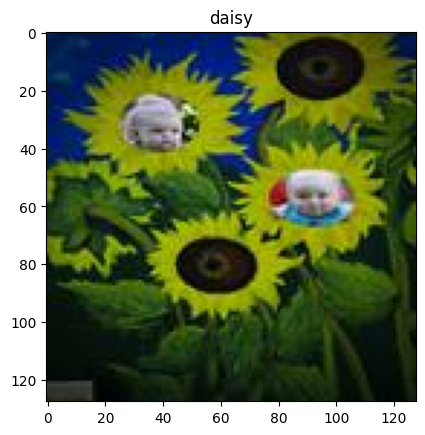

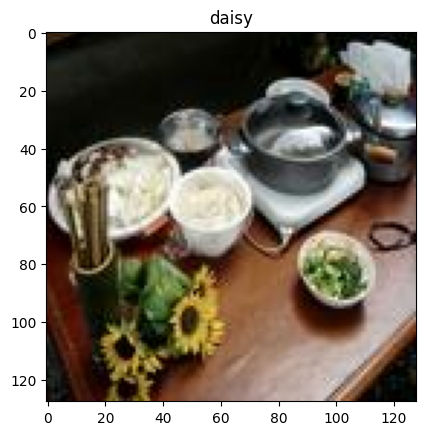

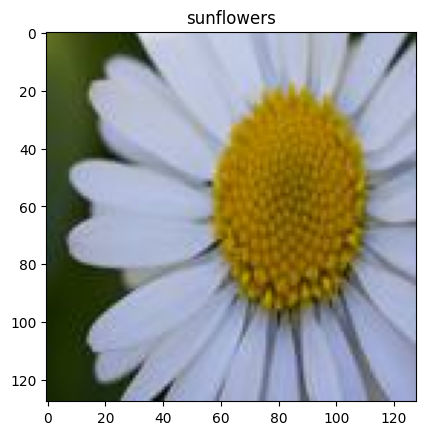

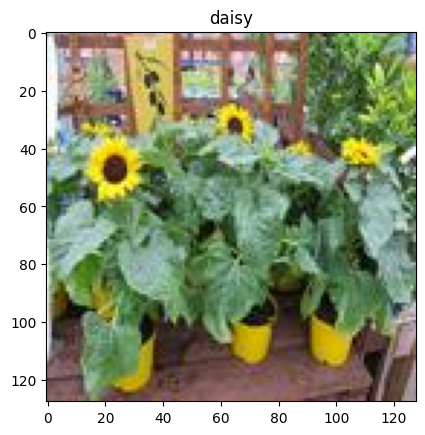

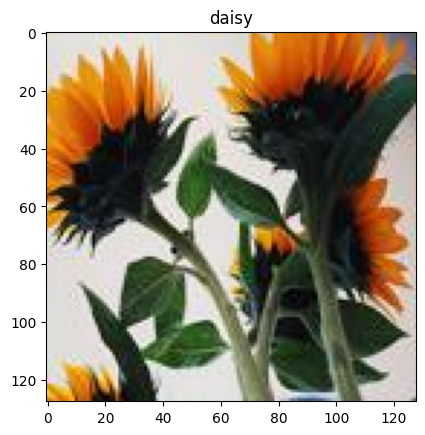

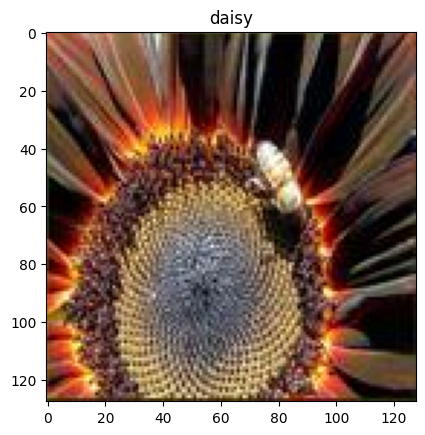

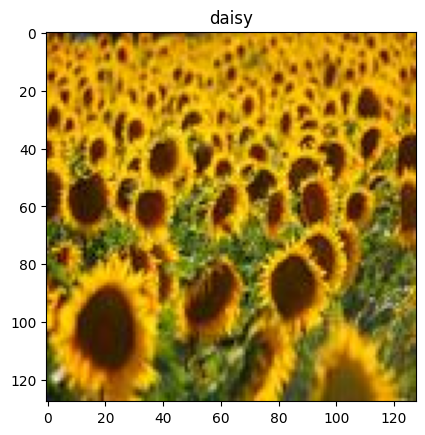

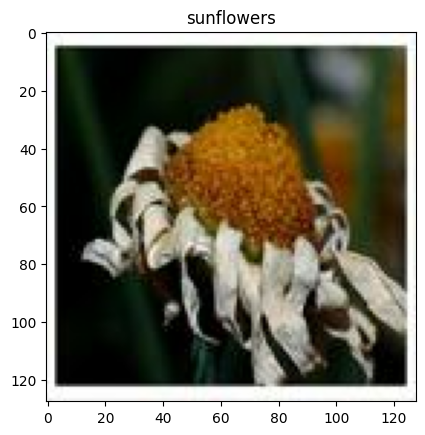

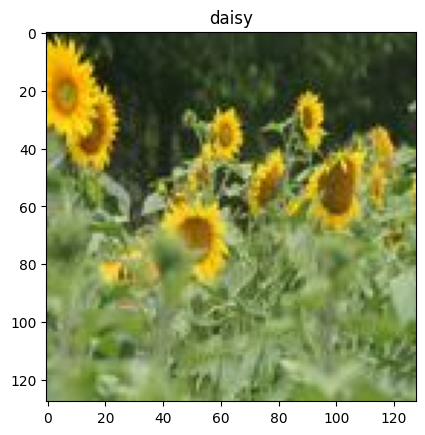

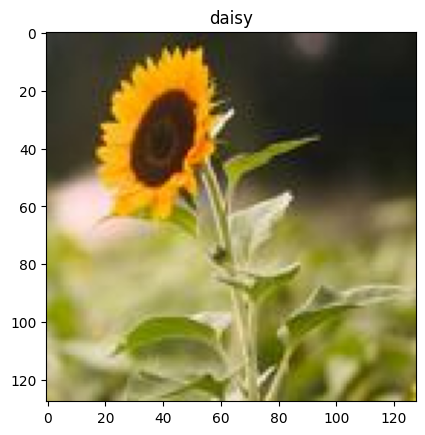

 missed 10 out of 64
# images 64
2/2 [==============================] - 0s 16ms/step


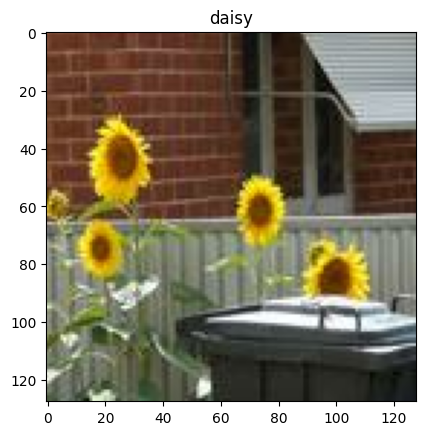

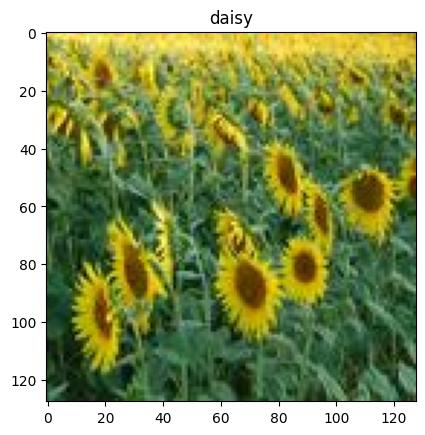

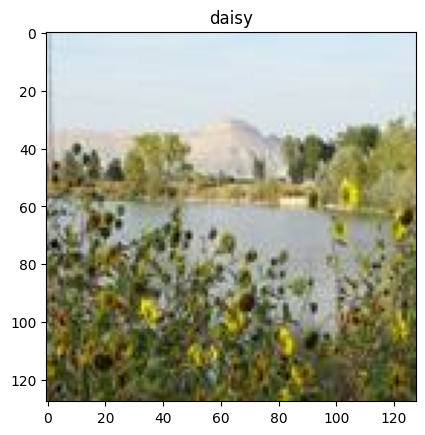

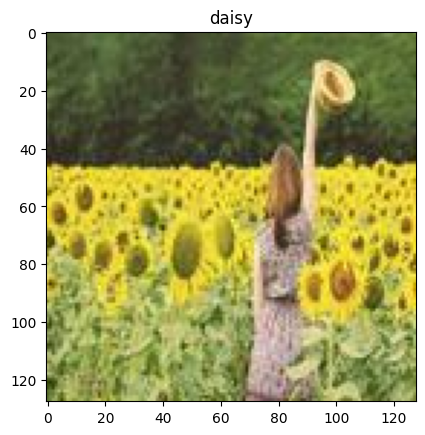

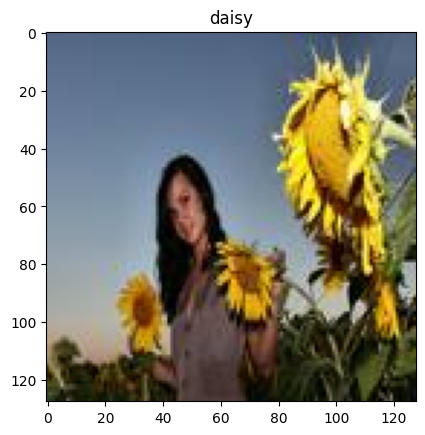

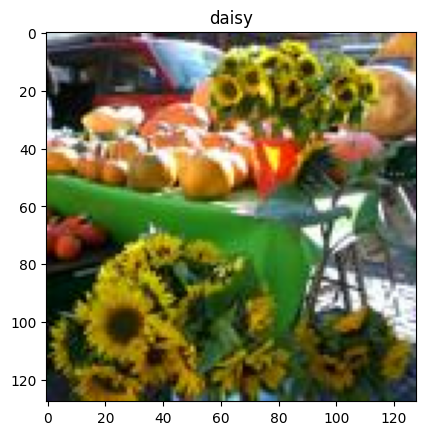

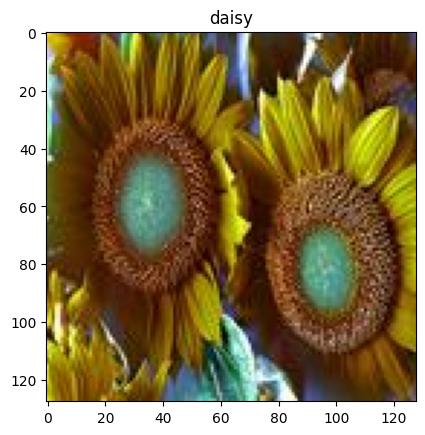

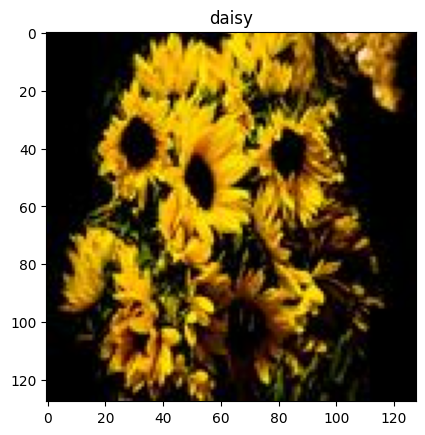

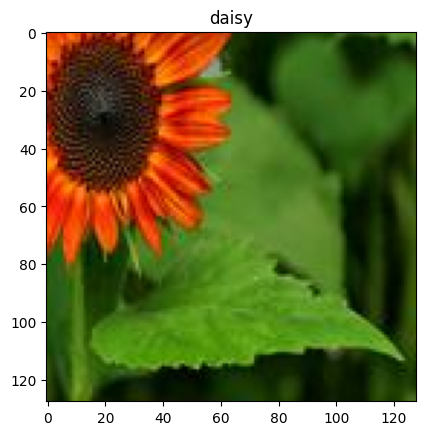

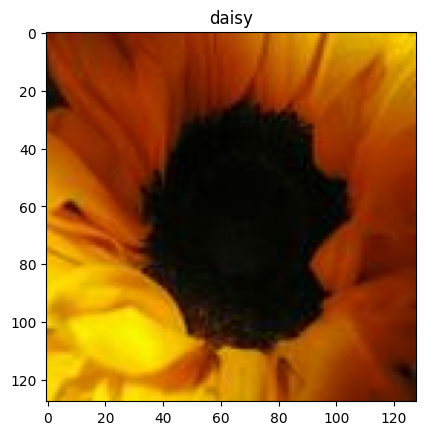

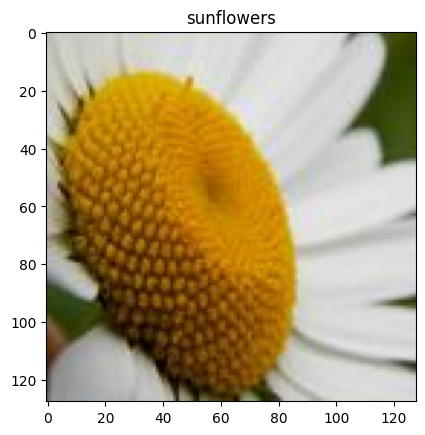

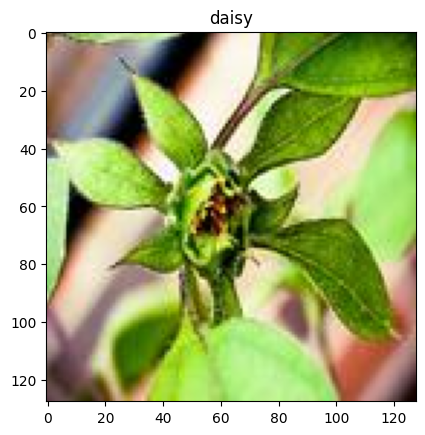

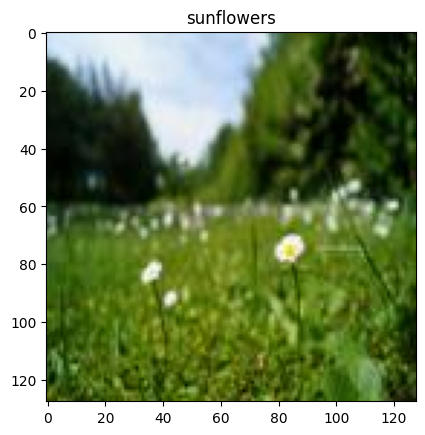

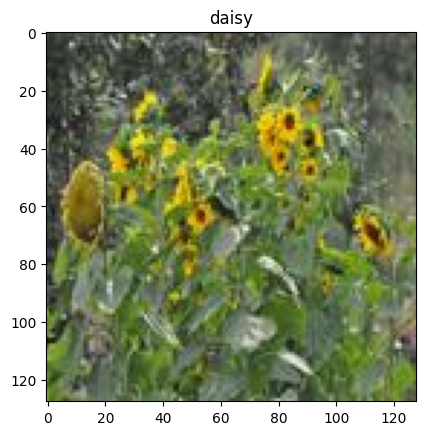

 missed 14 out of 64


In [ ]:
for images, labels in val_ds.take(2):
    n_images = len(images)
    print(f"# images {n_images}")
    res = model.predict(images)
    pred_labels = (res[:,0] > 0.5).astype(int)
    pred_class = [class_names[p] for p in pred_labels]
    missed = 0
    for i, label in enumerate(labels):
        if label != pred_labels[i]:
            missed += 1
            ax = plt.subplot()
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[pred_labels[i]])
            plt.show()
    print (f" missed {missed} out of {n_images}")

<font color=BLUE>
    
## Analysis of Misclassified
The classification results as well as what goes into the validation sets  
    changes on each run.
 
 First, some of the sunflower images, at least to me, clearly look like sunflowers.
    So there appears to be plenty of room for improvement in the classifier.
    
I would also say that some of the misclassified images are in general very difficult.  
Again, it will be different on each run so I won't mention specific images.
    
Perhaps a more or wider layers could do better.  
 I did actually try another convolution pooling layer but thay never performed better.
    
 All in all, I would say not to bad for a first attempt.
    
</font>

<font color=BLUE>
    
## Summary
I would say that it is not too difficult to get started with something that does image classification with Keras.  
    
  I should say that I also tried a data set with shells vs. pebbles and got miserable results, so I switched to the flowers.

There is a lot more to do and learn about image classification/recognition, however, including 
* tuning the architecture, e.g. number and size of layers  
* hyper parameter tuning of things like learning rate, batch size, dropout, et ceters  

Possible next steps for me
* doing the same with PyTorch  
* multiclass classification

Stay tuned.

</font>